In [1]:
# basic dependencies

import numpy as np
from numpy import loadtxt
from numpy import savetxt

import pandas as pd
import math
import time

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly

torch.set_printoptions(precision=3)

###########

# botorch dependencies
import botorch

# data related
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize, normalize

# surrogate model specific
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch import fit_gpytorch_model

# qNEHVI specific
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement

# utilities
from botorch.optim.optimize import optimize_acqf
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from typing import Optional
from torch import Tensor
from botorch.exceptions import BadInitialCandidatesWarning

import warnings

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

###########

# pymoo dependencies
import pymoo

from pymoo.problems import get_problem
from pymoo.core.problem import ElementwiseProblem

from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize

from pymoo.core.problem import Problem as PymooProblem
from pymoo.core.termination import NoTermination

###########

# jmetalpy dependencies
from jmetal.core.problem import FloatProblem
from jmetal.core.solution import FloatSolution
from jmetal.util.termination_criterion import StoppingByEvaluations, TerminationCriterion
from jmetal.util.aggregative_function import Tschebycheff
from jmetal.operator import PolynomialMutation, DifferentialEvolutionCrossover
from jmetal.algorithm.multiobjective.moead import Permutation
from jmetal.algorithm.multiobjective import MOEADIEpsilon


###########

from scipy.stats import qmc
from scipy.stats import gaussian_kde # for density plot

###########

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

# this is for the colorbar, you can change the cmap if you prefer other colour schemes
from matplotlib.cm import ScalarMappable
cm = plt.cm.get_cmap('viridis')

# function to return the std dev across runs
def ci(y, N_TRIALS):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
def optimize_qnehvi(problem, ref_point, initial_x, # must haves
                    N_BATCH, BATCH_SIZE, 
                    random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with Pure qNEHVI")

    t0 = time.time()

    # some initializing 
    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)
    
    ##########
    
    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)
    
    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
        
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    # original location for an extra HV check wrt to initial samples
    
    ########## ########## ########## start of iteration loop


    # training loop for N_BATCH iterations
    for iteration in range(1, N_BATCH + 1):    

        t3 = time.time()
                
        # fit the surrogate model
        fit_gpytorch_model(mll)    
                
        ##########
            
        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            constraints=create_idxrs(), # constraint on last n_constr col
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on
        
        ##########
        
        # propose candidates given defined qNEHVI acq func given model and latest observed training data
        new_x, _ = optimize_acqf(
                        acq_function=acq_func,
                        bounds=standard_bounds, # since train_x was normalized
                        q=BATCH_SIZE, # no of candidates to propose in parallel
                        num_restarts=2, # no of restarts of raw_samples
                        raw_samples=256,  # pool of samples to choose the starting points from
                        options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                        )

        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)

        # feed new proposed observations into objective func to get its new ground truth
        new_obj, new_con = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
        new_con_noisy = new_con + noise*torch.randn_like(new_con)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])
        
        ##########
        
        # computing HV of current candidate list
        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0
        
        hvs.append(volume)
        
        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        
        ##########
        
        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")
            
        del new_x, new_obj, new_con, new_obj_noisy, new_con_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial     
        
        ########## ########## ########## end of iteration loop

    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")       
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy()

In [3]:
def optimize_hybrid_nsga(problem, ref_point, initial_x, # must haves
                         N_BATCH, BATCH_SIZE, 
                         random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with Hybrid qNEHVI + U-NSGA-III")

    t0 = time.time()

    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    pymooproblem = PymooProblem(n_var=problem.n_var, n_obj=problem.n_obj, n_constr=problem.n_constr, 
                  xl=np.zeros(problem.n_var), xu=np.ones(problem.n_var))

    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    ########## ########## ########## start of iteration loop

    for iteration in range(1, N_BATCH + 1):   

        t3 = time.time()

        ##########

        fit_gpytorch_model(mll)  

        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            constraints=create_idxrs(), # constraint on last n_constr col
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

        # propose best candidates given QMC and qNEHVI
        qnehvi_x, _ = optimize_acqf(acq_function=acq_func,
                                    bounds=standard_bounds, # since train_x was normalized
                                    q=BATCH_SIZE, # no of candidates to propose in parallel, 12 is the max for a GTX1065
                                    num_restarts=1, # no of restarts if q candidates fail to show improvement
                                    raw_samples=256,  # pool of samples to choose the starting points from
                                    options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                                 )

        ##########
       
        algorithm = UNSGA3(pop_size=256,
                           ref_dirs=get_reference_directions("energy", problem.n_obj, 256, seed=random_state),
                           sampling=train_x_gp.cpu().numpy(),
                          )

        algorithm.setup(pymooproblem, termination=NoTermination())

        # set the 1st population to the current evaluated population
        pop = algorithm.ask()
        pop.set("F", train_obj_noisy.cpu().numpy())
        pop.set("G", train_con_noisy.cpu().numpy())
        algorithm.tell(infills=pop)

        # propose children based on tournament selection -> crossover/mutation
        newpop = algorithm.ask()
        nsga3_x = torch.tensor(newpop.get("X"), **tkwargs)
        
        ##########

        candidates = torch.cat([qnehvi_x, nsga3_x])

        acq_value_list = []

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                acq_value = acq_func(candidates[i].unsqueeze(dim=0))
                acq_value_list.append(acq_value.item())

        pred_hv_list = []
        model.eval();

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                posterior = model.posterior(candidates[i].unsqueeze(0))
                pred_y = posterior.mean
                pred_hv = hv.compute(pred_y[:,:problem.n_obj])
                pred_hv_list.append(pred_hv)

        sorted_x = candidates.cpu().numpy()[np.lexsort((pred_hv_list, acq_value_list))]

        ##########
        
        new_x = torch.tensor(sorted_x[-BATCH_SIZE:], **tkwargs) # take best BATCH_SIZE samples
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)
        new_obj, new_con = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
        new_con_noisy = new_con + noise*torch.randn_like(new_con)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])

        # computing HV of current candidate list
        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0

        hvs.append(volume)

        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)

        ##########

        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")

        del new_x, new_obj, new_con, qnehvi_x, nsga3_x, new_obj_noisy, new_con_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
        
    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")   
    
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy()

In [4]:
def optimize_hybrid_moead(problem, ref_point, initial_x, # must haves
                         N_BATCH, BATCH_SIZE, 
                         random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with Hybrid qNEHVI + MOEAD")

    t0 = time.time()

    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    # define jmetal class
    class jmetalproblem(FloatProblem):

        def __init__(self):
            super(jmetalproblem, self).__init__()
            self.number_of_variables = problem.n_var
            self.number_of_objectives = problem.n_obj
            self.number_of_constraints = problem.n_constr

            obj_directions = []
            obj_labels = []

            for i in range(1,problem.n_obj+1):
                obj_directions.append(self.MINIMIZE)
                obj_labels.append(f'f{i}')

            self.obj_directions = obj_directions
            self.obj_labels = obj_labels

            self.lower_bound = [0.0] * problem.n_var
            self.upper_bound = [1.0] * problem.n_var

        def evaluate(self, solution: FloatSolution) -> FloatSolution:
            pass

        def get_name(self):
            return 'jmetalproblem'

    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    ########## ########## ########## start of iteration loop

    for iteration in range(1, N_BATCH + 1):   

        t3 = time.time()

        ##########

        fit_gpytorch_model(mll)  

        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            constraints=create_idxrs(), # constraint on last n_constr col
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

        # propose best candidates given QMC and qNEHVI
        qnehvi_x, _ = optimize_acqf(acq_function=acq_func,
                                    bounds=standard_bounds, # since train_x was normalized
                                    q=BATCH_SIZE, # no of candidates to propose in parallel, 12 is the max for a GTX1065
                                    num_restarts=1, # no of restarts if q candidates fail to show improvement
                                    raw_samples=256,  # pool of samples to choose the starting points from
                                    options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                                 )

        ##########
        
        max_pop = train_x_gp.shape[0]
        
        # redefine a new algo at each iteration
        MOEAD_algo = MOEADIEpsilon(problem=jmetalproblem(),
                          population_size=max_pop,
                          crossover=DifferentialEvolutionCrossover(CR=1.0, F=0.5, K=0.5),
                          mutation=PolynomialMutation(probability=1.0 / jmetalproblem().number_of_variables, distribution_index=20),
                          aggregative_function=Tschebycheff(dimension=jmetalproblem().number_of_objectives),
                          neighbor_size=int(max_pop/2),
                          neighbourhood_selection_probability=0.9,
                          max_number_of_replaced_solutions=2,
                          weight_files_path='weights',
                          #termination_criterion=StoppingByEvaluations(BATCH_SIZE),
                         )
        
        
        # initialize population
        initial_solutions = []

        for i in range(0, max_pop):
            solution1 = FloatSolution(lower_bound=[0.0] * problem.n_var,
                                      upper_bound=[1.0] * problem.n_var,
                                      number_of_objectives=problem.n_obj,
                                      number_of_constraints=problem.n_constr,
                                     )
            solution1.variables = train_x_gp[i].cpu().tolist()
            solution1.objectives = train_obj_noisy[i].cpu().tolist()
            solution1.constraints = train_con_noisy[i].cpu().tolist()
            
            initial_solutions.append(solution1)

        MOEAD_algo.solutions = initial_solutions

        # perform selection, crossover and mutation to form our offspring population
        MOEAD_algo.permutation = Permutation(max_pop)
        offspring_population = []

        for q in range(256):
            mating_population = MOEAD_algo.selection(MOEAD_algo.solutions)
            offspring = MOEAD_algo.reproduction(mating_population)
            offspring_population.append(offspring[0].variables)
            
        moead_x = torch.tensor(offspring_population, **tkwargs)
        
        ##########

        candidates = torch.cat([qnehvi_x, moead_x])

        acq_value_list = []

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                acq_value = acq_func(candidates[i].unsqueeze(dim=0))
                acq_value_list.append(acq_value.item())

        pred_hv_list = []
        model.eval();

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                posterior = model.posterior(candidates[i].unsqueeze(0))
                pred_y = posterior.mean
                pred_hv = hv.compute(pred_y[:,:problem.n_obj])
                pred_hv_list.append(pred_hv)

        sorted_x = candidates.cpu().numpy()[np.lexsort((pred_hv_list, acq_value_list))]

        ##########
        
        new_x = torch.tensor(sorted_x[-BATCH_SIZE:], **tkwargs) # take best BATCH_SIZE samples
        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)

        # feed new proposed observations into objective func to get its new ground truth
        new_obj, new_con = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
        new_con_noisy = new_con + noise*torch.randn_like(new_con)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])

        # computing HV of current candidate list
        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0

        hvs.append(volume)

        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)

        ##########

        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")

        del new_x, new_obj, new_con, qnehvi_x, moead_x, new_obj_noisy, new_con_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
        
    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")   
    
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy()

In [9]:
import joblib

gp_dict = joblib.load('3d_gp_dict')


lowerbound = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.0], **tkwargs)
upperbound = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0], **tkwargs)

dimensions = 6

class Problem_3d(torch.nn.Module):
    # must define these!
    n_var = 6
    n_obj = 3
    n_constr = 1
    
    ref_point = torch.tensor([0, 0, 0], **tkwargs)
        
    # input bounds, don't forget to change according to n_var! 
    bounds = torch.vstack([lowerbound,upperbound])
    
    def evaluate(X):
        X_np = X.cpu().numpy() 
        
        y1 = gp_dict['CS'].predict(X_np)
        y2 = gp_dict['CM'].predict(X_np)
        y3 = gp_dict['TS'].predict(X_np)
        
        y_combined = np.stack([y1,y2,y3], axis=1)
        output = torch.tensor(y_combined, **tkwargs)
        slack = (torch.sum(X, dim=1) - 1)**2 - 0.001 # we add an epilson of 0.1% 
        
        return output, slack.unsqueeze(dim=-1)
    
initial_x_array = loadtxt("initial_x_10trials6dim_01bounds.csv", delimiter=',')
initial_x_array = initial_x_array.reshape(10, 14, 6)

In [10]:
problem = Problem_3d
problemname = "3d"

N_TRIALS = 10
verbose = True
noise = 0.00

N_BATCH = 24
BATCH_SIZE = 8

hvs_qnehvi = []
train_qnehvi = []

# main loop for each trial/run, random_state will be trial number
for trial in range(0, N_TRIALS):
    print(f"\nTrial {trial+1:>2} of {N_TRIALS} for problem {problemname} with d = {dimensions}\n", end="")

    # initialize with a 2*(d+1) sample set
    initial_x = torch.tensor(initial_x_array[trial], **tkwargs)
    
    hv, train = optimize_qnehvi(problem, problem.ref_point, initial_x,
                     N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                     random_state=trial, noise=noise, verbose=verbose)
    hvs_qnehvi.append(hv)
    train_qnehvi.append(train)
    
    
savetxt(f"{problemname}_hvs_qnehvi_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", hvs_qnehvi, delimiter=',')    
savetxt(f"{problemname}_train_qnehvi_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", np.array(train_qnehvi).reshape(-1), delimiter=',')

print("ALL DONE!")


Trial  1 of 10 for problem 3d with d = 6
Optimizing with Pure qNEHVI


C:\Users\user\anaconda3\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


Batch  1 of 24: Hypervolume = 0.00, time = 36.39s.
Batch  2 of 24: Hypervolume = 0.00, time = 29.29s.
Batch  3 of 24: Hypervolume = 0.00, time = 29.32s.
Batch  4 of 24: Hypervolume = 0.19, time = 16.62s.
Batch  5 of 24: Hypervolume = 0.19, time = 25.93s.
Batch  6 of 24: Hypervolume = 0.19, time = 25.76s.
Batch  7 of 24: Hypervolume = 0.20, time = 27.60s.
Batch  8 of 24: Hypervolume = 0.20, time = 10.96s.
Batch  9 of 24: Hypervolume = 0.20, time = 5.12s.
Batch 10 of 24: Hypervolume = 0.20, time = 26.70s.
Batch 11 of 24: Hypervolume = 0.21, time = 28.24s.
Batch 12 of 24: Hypervolume = 0.21, time = 31.94s.
Batch 13 of 24: Hypervolume = 0.21, time = 30.15s.
Batch 14 of 24: Hypervolume = 0.21, time = 32.17s.
Batch 15 of 24: Hypervolume = 0.21, time = 34.68s.
Batch 16 of 24: Hypervolume = 0.21, time = 37.15s.
Batch 17 of 24: Hypervolume = 0.21, time = 34.89s.
Batch 18 of 24: Hypervolume = 0.21, time = 27.82s.
Batch 19 of 24: Hypervolume = 0.40, time = 34.63s.
Batch 20 of 24: Hypervolume = 0.

Batch  7 of 24: Hypervolume = 0.00, time = 23.04s.
Batch  8 of 24: Hypervolume = 0.00, time = 19.97s.
Batch  9 of 24: Hypervolume = 0.00, time = 13.91s.
Batch 10 of 24: Hypervolume = 0.00, time = 28.74s.
Batch 11 of 24: Hypervolume = 0.09, time = 8.02s.
Batch 12 of 24: Hypervolume = 0.09, time = 7.61s.
Batch 13 of 24: Hypervolume = 0.09, time = 28.71s.
Batch 14 of 24: Hypervolume = 0.09, time = 10.48s.
Batch 15 of 24: Hypervolume = 0.40, time = 31.09s.
Batch 16 of 24: Hypervolume = 0.41, time = 14.75s.
Batch 17 of 24: Hypervolume = 0.41, time = 31.66s.
Batch 18 of 24: Hypervolume = 0.42, time = 27.47s.
Batch 19 of 24: Hypervolume = 0.42, time = 29.52s.
Batch 20 of 24: Hypervolume = 0.42, time = 29.66s.
Batch 21 of 24: Hypervolume = 0.42, time = 14.14s.
Batch 22 of 24: Hypervolume = 0.42, time = 32.74s.
Batch 23 of 24: Hypervolume = 0.42, time = 6.96s.
Batch 24 of 24: Hypervolume = 0.42, time = 34.92s.
Time taken in total: 535.22s.

Trial  8 of 10 for problem 3d with d = 6
Optimizing wi

KeyboardInterrupt: 

In [6]:
problem = Problem_3d
problemname = "3d"

N_TRIALS = 10
verbose = True
noise = 0.00

N_BATCH = 24
BATCH_SIZE = 8

hvs_hybrid_nsga = []
train_hybrid_nsga = []

# main loop for each trial/run, random_state will be trial number
for trial in range(0, N_TRIALS):
    print(f"\nTrial {trial+1:>2} of {N_TRIALS} for problem {problemname} with d = {dimensions}\n", end="")

    # initialize with a 2*(d+1) sample set
    initial_x = torch.tensor(initial_x_array[trial], **tkwargs)
    
    hv, train = optimize_hybrid_nsga(problem, problem.ref_point, initial_x,
                     N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                     random_state=trial, noise=noise, verbose=verbose)
    hvs_hybrid_nsga.append(hv)
    train_hybrid_nsga.append(train)
    
    
savetxt(f"{problemname}_hvs_hybrid_nsga_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", hvs_hybrid_nsga, delimiter=',')    
savetxt(f"{problemname}_train_hybrid_nsga_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", np.array(train_hybrid_nsga).reshape(-1), delimiter=',')

print("ALL DONE!")


Trial  1 of 10 for problem MW5 with d = 8
Optimizing with Hybrid qNEHVI + U-NSGA-III


C:\Users\user\anaconda3\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


Batch  1 of 24: Hypervolume = 0.00, time = 11.30s.
Batch  2 of 24: Hypervolume = 0.00, time = 44.45s.
Batch  3 of 24: Hypervolume = 0.00, time = 34.76s.
Batch  4 of 24: Hypervolume = 0.00, time = 33.81s.
Batch  5 of 24: Hypervolume = 0.00, time = 15.00s.
Batch  6 of 24: Hypervolume = 0.13, time = 12.21s.
Batch  7 of 24: Hypervolume = 0.22, time = 25.74s.
Batch  8 of 24: Hypervolume = 0.22, time = 29.85s.
Batch  9 of 24: Hypervolume = 0.28, time = 17.30s.
Batch 10 of 24: Hypervolume = 0.30, time = 17.72s.
Batch 11 of 24: Hypervolume = 0.32, time = 32.40s.
Batch 12 of 24: Hypervolume = 0.32, time = 13.72s.
Batch 13 of 24: Hypervolume = 0.32, time = 19.12s.
Batch 14 of 24: Hypervolume = 0.40, time = 20.05s.
Batch 15 of 24: Hypervolume = 0.41, time = 15.37s.
Batch 16 of 24: Hypervolume = 0.48, time = 21.44s.
Batch 17 of 24: Hypervolume = 0.50, time = 30.52s.
Batch 18 of 24: Hypervolume = 0.51, time = 22.09s.
Batch 19 of 24: Hypervolume = 0.51, time = 11.93s.
Batch 20 of 24: Hypervolume = 0

Batch  5 of 24: Hypervolume = 0.18, time = 19.98s.
Batch  6 of 24: Hypervolume = 0.19, time = 19.05s.
Batch  7 of 24: Hypervolume = 0.24, time = 30.58s.
Batch  8 of 24: Hypervolume = 0.25, time = 11.99s.
Batch  9 of 24: Hypervolume = 0.28, time = 35.76s.
Batch 10 of 24: Hypervolume = 0.30, time = 13.72s.
Batch 11 of 24: Hypervolume = 0.30, time = 29.23s.
Batch 12 of 24: Hypervolume = 0.30, time = 22.25s.
Batch 13 of 24: Hypervolume = 0.30, time = 20.50s.
Batch 14 of 24: Hypervolume = 0.37, time = 17.30s.
Batch 15 of 24: Hypervolume = 0.38, time = 11.77s.
Batch 16 of 24: Hypervolume = 0.44, time = 18.83s.
Batch 17 of 24: Hypervolume = 0.46, time = 21.40s.
Batch 18 of 24: Hypervolume = 0.46, time = 28.88s.
Batch 19 of 24: Hypervolume = 0.49, time = 20.45s.
Batch 20 of 24: Hypervolume = 0.50, time = 12.49s.
Batch 21 of 24: Hypervolume = 0.50, time = 11.01s.
Batch 22 of 24: Hypervolume = 0.50, time = 16.76s.
Batch 23 of 24: Hypervolume = 0.50, time = 15.59s.
Batch 24 of 24: Hypervolume = 0

In [7]:
problem = Problem_MW7
problemname = "MW7"

N_TRIALS = 10
verbose = True
noise = 0.00

N_BATCH = 24
BATCH_SIZE = 8

hvs_hybrid_moead = []
train_hybrid_moead = []

# main loop for each trial/run, random_state will be trial number
for trial in range(0, N_TRIALS):
    print(f"\nTrial {trial+1:>2} of {N_TRIALS} for problem {problemname} with d = {dimensions}\n", end="")

    # initialize with a 2*(d+1) sample set
    initial_x = torch.tensor(initial_x_array[trial], **tkwargs)
    
    hv, train = optimize_hybrid_moead(problem, problem.ref_point, initial_x,
                     N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                     random_state=trial, noise=noise, verbose=verbose)
    hvs_hybrid_moead.append(hv)
    train_hybrid_moead.append(train)
    
    
savetxt(f"{problemname}_hvs_hybrid_moead_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", hvs_hybrid_moead, delimiter=',')    
savetxt(f"{problemname}_train_hybrid_moead_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", np.array(train_hybrid_moead).reshape(-1), delimiter=',')

print("ALL DONE!")


Trial  1 of 10 for problem MW7 with d = 8
Optimizing with Hybrid qNEHVI + MOEAD
Batch  1 of 24: Hypervolume = 0.00, time = 19.23s.
Batch  2 of 24: Hypervolume = 0.12, time = 23.74s.
Batch  3 of 24: Hypervolume = 0.12, time = 35.95s.
Batch  4 of 24: Hypervolume = 0.23, time = 10.02s.
Batch  5 of 24: Hypervolume = 0.27, time = 29.69s.
Batch  6 of 24: Hypervolume = 0.29, time = 8.06s.
Batch  7 of 24: Hypervolume = 0.32, time = 38.65s.
Batch  8 of 24: Hypervolume = 0.32, time = 25.79s.
Batch  9 of 24: Hypervolume = 0.35, time = 15.87s.
Batch 10 of 24: Hypervolume = 0.36, time = 28.12s.
Batch 11 of 24: Hypervolume = 0.36, time = 16.61s.
Batch 12 of 24: Hypervolume = 0.39, time = 11.10s.
Batch 13 of 24: Hypervolume = 0.39, time = 7.45s.
Batch 14 of 24: Hypervolume = 0.41, time = 35.16s.
Batch 15 of 24: Hypervolume = 0.41, time = 10.39s.
Batch 16 of 24: Hypervolume = 0.41, time = 21.72s.
Batch 17 of 24: Hypervolume = 0.41, time = 29.27s.
Batch 18 of 24: Hypervolume = 0.41, time = 26.67s.
Bat

Batch  4 of 24: Hypervolume = 0.17, time = 20.08s.
Batch  5 of 24: Hypervolume = 0.19, time = 17.36s.
Batch  6 of 24: Hypervolume = 0.20, time = 13.20s.
Batch  7 of 24: Hypervolume = 0.25, time = 16.34s.
Batch  8 of 24: Hypervolume = 0.26, time = 26.14s.
Batch  9 of 24: Hypervolume = 0.26, time = 18.65s.
Batch 10 of 24: Hypervolume = 0.35, time = 17.10s.
Batch 11 of 24: Hypervolume = 0.36, time = 12.63s.
Batch 12 of 24: Hypervolume = 0.36, time = 12.46s.
Batch 13 of 24: Hypervolume = 0.37, time = 13.91s.
Batch 14 of 24: Hypervolume = 0.37, time = 13.20s.
Batch 15 of 24: Hypervolume = 0.37, time = 8.35s.
Batch 16 of 24: Hypervolume = 0.39, time = 28.02s.
Batch 17 of 24: Hypervolume = 0.39, time = 11.29s.
Batch 18 of 24: Hypervolume = 0.40, time = 11.30s.
Batch 19 of 24: Hypervolume = 0.40, time = 27.32s.
Batch 20 of 24: Hypervolume = 0.40, time = 15.67s.
Batch 21 of 24: Hypervolume = 0.40, time = 30.09s.
Batch 22 of 24: Hypervolume = 0.41, time = 8.21s.
Batch 23 of 24: Hypervolume = 0.4

In [9]:
problem = Problem_MW7
problemname = "MW7"

N_TRIALS = 3
verbose = True
noise = 0.00

N_BATCH = 16
BATCH_SIZE = 8

hvs_qnehvi, hvs_parallel_nsga, hvs_parallel_moead, hvs_hybrid_nsga, hvs_hybrid_moead = [], [], [], [], []
train_qnehvi, train_parallel_nsga, train_parallel_moead, train_hybrid_nsga, train_hybrid_moead = [], [], [], [], []


# main loop for each trial/run, random_state will be trial number
for trial in range(0, N_TRIALS):
    print(f"\nTrial {trial+1:>2} of {N_TRIALS} for problem {problemname} with d = {dimensions}\n", end="")

    # initialize with a 2*(d+1) sample set
    initial_x = torch.tensor(initial_x_array[trial], **tkwargs)
    
    for algo, hv_list, train_list in zip([optimize_qnehvi, optimize_parallel_nsga, optimize_parallel_moead,
                                          optimize_hybrid_nsga, optimize_hybrid_moead],
                                         [hvs_qnehvi, hvs_parallel_nsga, hvs_parallel_moead, hvs_hybrid_nsga, hvs_hybrid_moead],
                                         [train_qnehvi, train_parallel_nsga, train_parallel_moead, train_hybrid_nsga, train_hybrid_moead]
                                        ):
    
        hv, train = algo(problem, problem.ref_point, initial_x,
                         N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                         random_state=trial, noise=noise, verbose=verbose)
        hv_list.append(hv)
        train_list.append(train)
    
for algo_name, hv_list, train_list in zip(
    ['qnehvi', 'parallel_nsga', 'parallel_moead', 'hybrid_nsga', 'hybrid_moead'],
    [hvs_qnehvi, hvs_parallel_nsga, hvs_parallel_moead, hvs_hybrid_nsga, hvs_hybrid_moead],
    [train_qnehvi, train_parallel_nsga, train_parallel_moead, train_hybrid_nsga, train_hybrid_moead]):
    
    savetxt(f"{problemname}_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", hv_list, delimiter=',')    
    savetxt(f"{problemname}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", np.array(train_list).reshape(-1), delimiter=',')

print("ALL DONE!")


Trial  1 of 3 for problem <class '__main__.Problem_MW7'> with d = 8
Optimizing with Pure qNEHVI
Batch  1 of 16: Hypervolume = 0.00, time = 1.40s.
Batch  2 of 16: Hypervolume = 0.00, time = 33.16s.
Batch  3 of 16: Hypervolume = 0.00, time = 39.70s.
Batch  4 of 16: Hypervolume = 0.10, time = 36.13s.
Batch  5 of 16: Hypervolume = 0.10, time = 6.53s.
Batch  6 of 16: Hypervolume = 0.10, time = 28.73s.
Batch  7 of 16: Hypervolume = 0.13, time = 8.26s.
Batch  8 of 16: Hypervolume = 0.13, time = 24.77s.
Batch  9 of 16: Hypervolume = 0.13, time = 25.58s.
Batch 10 of 16: Hypervolume = 0.13, time = 33.97s.
Batch 11 of 16: Hypervolume = 0.13, time = 11.50s.
Batch 12 of 16: Hypervolume = 0.13, time = 24.49s.
Batch 13 of 16: Hypervolume = 0.13, time = 23.32s.
Batch 14 of 16: Hypervolume = 0.13, time = 8.49s.
Batch 15 of 16: Hypervolume = 0.13, time = 5.01s.
Batch 16 of 16: Hypervolume = 0.13, time = 23.06s.
Time taken in total: 334.19s.
Optimizing with Parallel qNEHVI + U-NSGA-III
Batch  1 of 16: H

Batch  4 of 16: Hypervolume = 0.11, time = 8.87s.
Batch  5 of 16: Hypervolume = 0.12, time = 30.60s.
Batch  6 of 16: Hypervolume = 0.20, time = 28.50s.
Batch  7 of 16: Hypervolume = 0.26, time = 6.50s.
Batch  8 of 16: Hypervolume = 0.26, time = 24.17s.
Batch  9 of 16: Hypervolume = 0.30, time = 20.25s.
Batch 10 of 16: Hypervolume = 0.36, time = 24.57s.
Batch 11 of 16: Hypervolume = 0.38, time = 25.78s.
Batch 12 of 16: Hypervolume = 0.38, time = 6.64s.
Batch 13 of 16: Hypervolume = 0.39, time = 25.02s.
Batch 14 of 16: Hypervolume = 0.39, time = 16.71s.
Batch 15 of 16: Hypervolume = 0.41, time = 6.89s.
Batch 16 of 16: Hypervolume = 0.42, time = 5.64s.
Time taken in total: 310.50s.

Trial  3 of 3 for problem <class '__main__.Problem_MW7'> with d = 8
Optimizing with Pure qNEHVI
Batch  1 of 16: Hypervolume = 0.00, time = 5.79s.
Batch  2 of 16: Hypervolume = 0.00, time = 3.67s.
Batch  3 of 16: Hypervolume = 0.00, time = 40.14s.
Batch  4 of 16: Hypervolume = 0.00, time = 10.57s.
Batch  5 of 1

In [14]:
'''
ref_point = torch.tensor([1.5,1.5], **tkwargs)
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
problem = get_problem("mw12")
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [1.5, 1.5], MW12 has a max HV of {volume}")

ref_point = torch.tensor([40,0.015], **tkwargs)
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
problem = get_problem("welded_beam")
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [40, 0.015], Welded Beam has a max HV of {volume}")

ref_point = torch.tensor([1.6,1.6], **tkwargs)
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
problem = get_problem("dascmop1", 4) # we use difficulty triple no4
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [1.6, 1.6], DASCMOP1 has a max HV of {volume}")
'''

from pymoo.problems import get_problem

ref_point = torch.tensor([1.1,1.1], **tkwargs)
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
problem = get_problem("mw3")
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [1.1, 1.1], MW3 has a max HV of {volume}")

ref_point = torch.tensor([1.2,1.2], **tkwargs)
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
problem = get_problem("mw5")
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [1.2, 1.2], MW5 has a max HV of {volume}")

ref_point = torch.tensor([1.2,1.2], **tkwargs)
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
problem = get_problem("mw7")
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [1.2, 1.2], MW7 has a max HV of {volume}")



Using pymoo's Pareto set with reference point of [1.1, 1.1], MW3 has a max HV of 0.6607563181459482
Using pymoo's Pareto set with reference point of [1.2, 1.2], MW5 has a max HV of 0.6229275708817372
Using pymoo's Pareto set with reference point of [1.2, 1.2], MW7 has a max HV of 0.5039622081235824


FileNotFoundError: MW3_hvs_hybrid_nsga_24by8_10trials.csv not found.

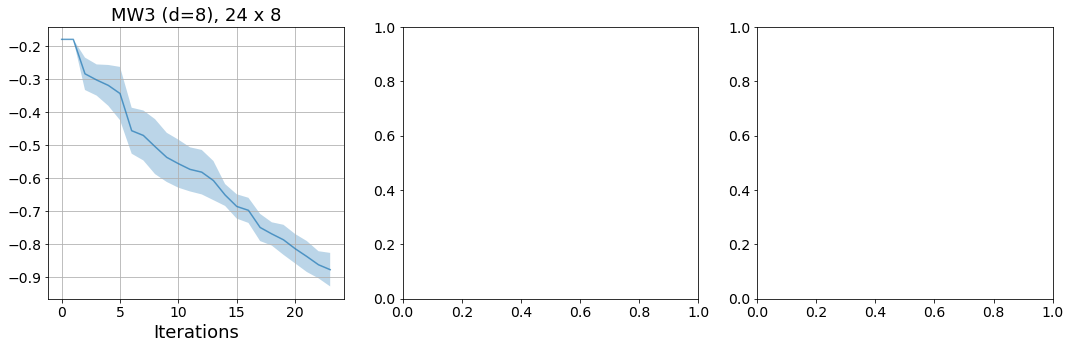

In [7]:
problemname = "ZDT1"
max_hv = 120.66140936892067

N_BATCH = 24
BATCH_SIZE = 8
N_TRIALS = 10

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for problemname, max_hv, idx in zip(
    ['MW3', 'MW5', 'MW7'],
    [0.6607563181459482, 0.6229275708817372, 0.5039622081235824],
    [0, 1, 2]):

    for algo_name, plot_name, in zip(
        ['qnehvi', 'hybrid_nsga', 'hybrid_moead'],
        ['Pure BO', 'Hybrid w/ NSGA', 'Hybrid w/ MOEAD']):

        hv_list = loadtxt(f"{problemname}_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
        hv_plot = np.log10(max_hv - np.asarray(hv_list))

        ax[idx].plot(np.arange(N_BATCH),
                hv_plot.mean(axis=0),
                label=f'{plot_name}', linewidth=1.5, alpha=0.7)

        ax[idx].fill_between(np.arange(N_BATCH),
                        hv_plot.mean(axis=0)-ci(hv_plot, N_TRIALS), hv_plot.mean(axis=0)+ci(hv_plot, N_TRIALS),
                        alpha=0.3)
    
        ax[idx].set(xlabel='Iterations')
        ax[idx].grid(True)
        ax[idx].set_title(f"{problemname} (d=8), {N_BATCH} x {BATCH_SIZE}", fontsize=18)

fig.tight_layout()        
ax[0].set(ylabel='Log Hypervolume Difference')
#ax.legend(loc='lower left')

In [ ]:
handles,labels = ax.get_legend_handles_labels()
fig_legend = plt.figure(figsize=(2,2))
axi = fig_legend.add_subplot(111)            
fig_legend.legend(handles, labels, loc='center', scatterpoints = 1)
axi.xaxis.set_visible(False)
axi.yaxis.set_visible(False)
axi.axis("off")
fig_legend.canvas.draw()
fig_legend.show()

[Text(0, 0.5, 'Cumltv Hypervolume Wastage')]

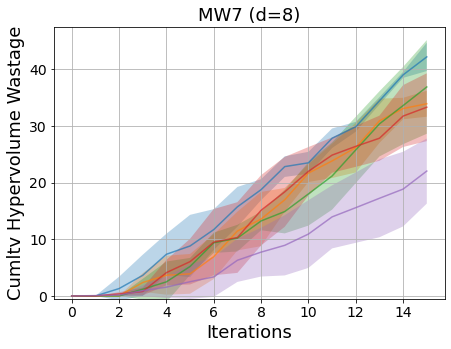

In [13]:
problem = Problem_MW7
problemname = "MW7"

N_BATCH = 16
BATCH_SIZE = 8
N_TRIALS = 3

ref_point = problem.ref_point
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation

basedict = {}
a = 0
b = 2*(problem.n_var+1)-1
for i in range(0, N_BATCH+1):

    basedict[i] = (a, b)
    # a stays at zero
    b+=BATCH_SIZE
    
newdict = {}
a = 2*(problem.n_var+1)
b = 2*(problem.n_var+1)+BATCH_SIZE-1
for i in range(0, N_BATCH):

    newdict[i] = (a, b)
    a+=BATCH_SIZE
    b+=BATCH_SIZE
    
fig, ax = plt.subplots(1, 1, figsize=(7, 5))    
    
for algo_name, plot_name, in zip(
    ['qnehvi', 'parallel_nsga', 'parallel_moead', 'hybrid_nsga', 'hybrid_moead'],
    ['Pure BO', 'Parallel w/ NSGA', 'Parallel w/ MOEAD', 'Hybrid w/ NSGA', 'Hybrid w/ MOEAD'],):
    
    train = loadtxt(f"{problemname}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    train = train.reshape(N_TRIALS, N_BATCH*BATCH_SIZE + 2*(problem.n_var+1), problem.n_var+problem.n_obj+problem.n_constr)

    hv_diff_list = []
    
    for trial in range(0, N_TRIALS):
        train_obj = torch.tensor(-train[trial][:,-problem.n_constr-problem.n_obj:-problem.n_constr], **tkwargs)
        train_con = torch.tensor(train[trial][:,-problem.n_constr:], **tkwargs)

        hv_diff_inner_list = []
        placeholder = 0

        for i in range(0, N_BATCH):
            base_obj = train_obj[basedict[i][0]:basedict[i][1]]
            base_con = train_con[basedict[i][0]:basedict[i][1]]

            is_feas = (base_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
            feas_train_obj = base_obj[is_feas] # take only points that fit the 1st check
            if feas_train_obj.shape[0] > 0:
                pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
                pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
                base_volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
            else:
                base_volume = 0.0

            new_obj = train_obj[newdict[i][0]:newdict[i][1]]
            new_con = train_con[newdict[i][0]:newdict[i][1]]

            is_feas = (new_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
            feas_train_obj = new_obj[is_feas] # take only points that fit the 1st check
            if feas_train_obj.shape[0] > 0:
                pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
                pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
                new_volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
            else:
                new_volume = 0.0

            hv_diff = base_volume - new_volume

            if hv_diff > 0:
                placeholder += hv_diff
                hv_diff_inner_list.append(placeholder)
            else:
                hv_diff_inner_list.append(placeholder) 

        hv_diff_list.append(hv_diff_inner_list)
        
    hv_diff_plot = np.asarray(hv_diff_list)

    ax.plot(np.arange(N_BATCH),
            hv_diff_plot.mean(axis=0),
            label=f'{plot_name}', linewidth=1.5, alpha=0.7)

    ax.fill_between(np.arange(N_BATCH),
                    hv_diff_plot.mean(axis=0)-ci(hv_diff_plot, N_TRIALS), hv_diff_plot.mean(axis=0)+ci(hv_diff_plot, N_TRIALS),
                    alpha=0.3)
    
ax.set_ylim(-0.5)

ax.set(xlabel='Iterations')
ax.grid(True)
ax.set_title(f"{problemname} (d=8)", fontsize=18)
ax.set(ylabel='Cumltv Hypervolume Wastage')
#ax.legend(loc='best')

[Text(117.0, 0.5, 'Feasibility Achievement')]

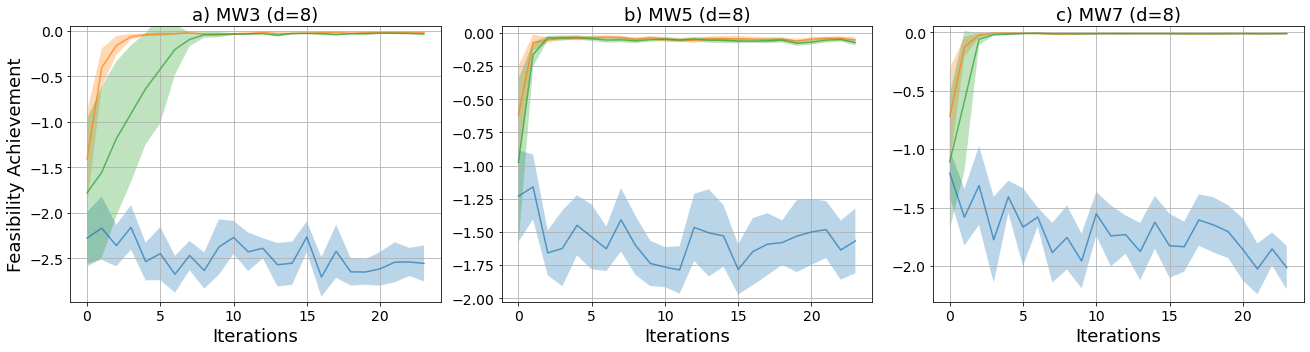

In [6]:
N_TRIALS = 10
N_BATCH = 24
BATCH_SIZE = 8
   
newdict = {}
a = 2*(8+1)
b = 2*(8+1)+BATCH_SIZE-1
for i in range(0, N_BATCH):

    newdict[i] = (a, b)
    a+=BATCH_SIZE
    b+=BATCH_SIZE  

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for problemname, problem, idx, sub in zip(
    ['MW3', 'MW5', 'MW7'],
    [Problem_MW3, Problem_MW5, Problem_MW7],
    [0, 1, 2],
    ['a', 'b', 'c']):

    for algo_name, plot_name, in zip(
        ['qnehvi', 'hybrid_nsga', 'hybrid_moead'],
        ['Pure BO', 'Hybrid w/ NSGA', 'Hybrid w/ MOEAD']):
    
        train = loadtxt(f"{problemname}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
        train = train.reshape(N_TRIALS, N_BATCH*BATCH_SIZE + 2*(problem.n_var+1), problem.n_var+problem.n_obj+problem.n_constr)

        feas_list = []
        for trial in range(N_TRIALS):
            train_con = torch.tensor(train[trial][:,-problem.n_constr:], **tkwargs)
            for row in range(0, train_con.shape[0]):
                for col in range(0, train_con.shape[1]):
                    if train_con[row,col]<=0:
                        train_con[row,col]=0

            feas_combined = train_con.sum(dim=1)
            feas_value = torch.log(feas_combined.max()) -torch.log(feas_combined+feas_combined.max())

            feas_list_inner = []
            for i in range(N_BATCH):
                feas_list_inner.append(feas_value[newdict[i][0]:newdict[i][1]].sum().cpu().numpy())

            feas_list.append(feas_list_inner)


        feas_plot = np.array(feas_list)    

        ax[idx].plot(np.arange(N_BATCH),
                feas_plot.mean(axis=0),
                label=f'{plot_name}', linewidth=1.5, alpha=0.7)

        ax[idx].fill_between(np.arange(N_BATCH),
                        feas_plot.mean(axis=0)-ci(feas_plot, N_TRIALS), feas_plot.mean(axis=0)+ci(feas_plot, N_TRIALS),
                        alpha=0.3)
 
        ax[idx].set_ylim(None, 0.05)
        ax[idx].set(xlabel='Iterations')
        ax[idx].grid(True)
        ax[idx].set_title(f"{sub}) {problemname} (d=8)", fontsize=18)

fig.tight_layout()                
ax[0].set(ylabel='Feasibility Achievement')
#ax.legend(loc='best')

Text(0.5, 1.0, 'PDF')

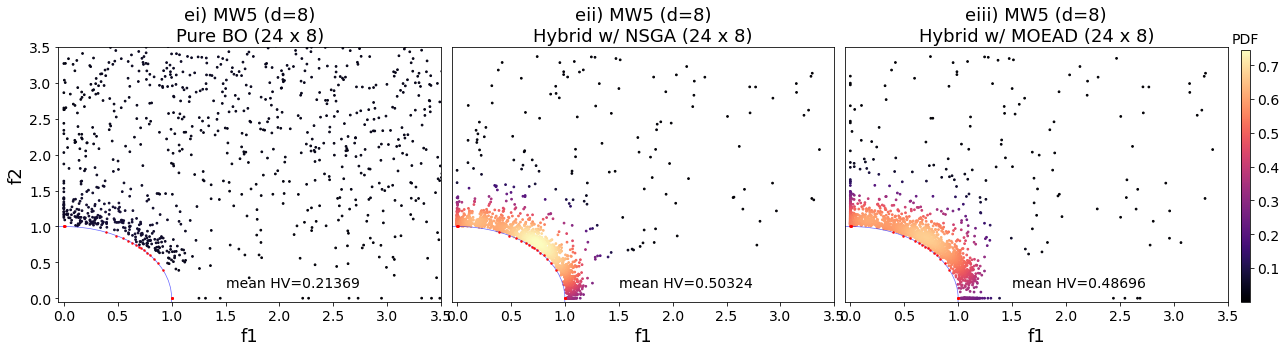

In [15]:
problemname = "MW5"
problem = Problem_MW5
problem1 = get_problem("mw5")
pareto = problem1.pareto_front()    

N_TRIALS = 10
N_BATCH = 24
BATCH_SIZE = 8

hv_list, x_list, y_list, z_list = [], [], [], []

for algo_name in (['qnehvi', 'hybrid_nsga', 'hybrid_moead']):
    
    hv = loadtxt(f"{problemname}_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    hv_list.append(hv)
    
    train = loadtxt(f"{problemname}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    train = train.reshape(N_TRIALS, N_BATCH*BATCH_SIZE + 2*(problem.n_var+1), problem.n_var+problem.n_obj+problem.n_constr)
    
    xlist, ylist = [], []

    for trial in range(N_TRIALS):

        xlist.append(-train[trial][:,-problem.n_obj-problem.n_constr:-problem.n_constr][:,0])
        ylist.append(-train[trial][:,-problem.n_obj-problem.n_constr:-problem.n_constr][:,1])

    x = np.array(xlist).reshape(-1)
    y = np.array(ylist).reshape(-1)
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    x_list.append(x)
    y_list.append(y)
    z_list.append(z)
    
fig, ax = plt.subplots(ncols = 3, figsize = (18,5))

norm = plt.Normalize(np.array(z_list).min(), np.array(z_list).max())

for plot_name, i, subsub in zip(
    ['Pure BO', 'Hybrid w/ NSGA', 'Hybrid w/ MOEAD'],
    [0, 1, 2],
    ['i', 'ii', 'iii']):
    

    ax[i].scatter(x_list[i], y_list[i], c=z_list[i], s=3, norm=norm, cmap='magma')
    
    #myarc = mpatches.Arc((0, 0), 2, 2, angle=0, theta1=0, theta2=360, color="blue", lw=0.7, alpha=0.6)
    #ax[i].add_artist(myarc)
    
    ax[i].add_patch(plt.Circle((0, 0), 1, color='b', fill=False, linewidth=0.7, alpha=0.6))
    
    #line1 = [0, 1]
    #line2 = [1, 0]
    #ax[i].plot(line1, line2, marker=',', linestyle='-', color='b', linewidth=0.7, alpha=0.6)
    
    ax[i].scatter(pareto[:,0],
                  pareto[:,1], 
                  c="r", s=10, marker=".", alpha=0.8)    
    
    ax[i].text(1.5, 0.15, f"mean HV={hv_list[i].mean(axis=0)[-1]:.5f}", fontsize=14)

    ax[i].set_title(f"e{subsub}) {problemname} (d={dimensions})\n{plot_name} ({N_BATCH} x {BATCH_SIZE})", fontsize=18)

    ax[i].set_xlim(-0.05, 3.50)
    ax[i].set_ylim(-0.05, 3.50)
    
    ax[i].set_xlabel('f1')
    ax[i].tick_params(axis='y', which='both', left=False, labelleft=False)

    
ax[0].tick_params(axis='y', which='both', left=True, labelleft=True)

ax[0].set_ylabel('f2')

fig.tight_layout()

sm = ScalarMappable(norm=norm, cmap='magma')
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.007, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("PDF", fontsize=14)